Task 1: Load the Dataset and Identify Customer Types

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Load the dataset
df = pd.read_csv('/content/sample_sales_data.csv')

In [3]:
# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (1348884, 11)

First few rows:
     customer_id       order_id    product_id  \
0  5140775469123  5594767982659  6.646609e+12   
1  6823449460803  5499271610435  6.646609e+12   
2  6958475968579  5583898902595  6.646608e+12   
3  6977967390787  5597642326083  6.646608e+12   
4  5548278874179  5585265262659  6.646608e+12   

                              product_name order_created_at  price  quantity  \
0  Ambery Cedarwood - Fragrance 50ml/1.7oz       2024-01-29   29.0         1   
1  Ambery Cedarwood - Fragrance 50ml/1.7oz       2024-01-02   29.0         1   
2     Ambery Cherry - Fragrance 50ml/1.7oz       2024-01-22   49.0         1   
3     Ambery Cherry - Fragrance 50ml/1.7oz       2024-01-30   49.0         1   
4     Ambery Cherry - Fragrance 50ml/1.7oz       2024-01-23   49.0         1   

   discounts  store_credit_by_product  refunded_quantity  refunded_amount  
0   4.350000                 0.000000                NaN              NaN  
1   5.800000              

In [4]:
# Check for "Dossier Plus" products
print("\nNumber of 'Dossier Plus' products:")
print(sum(df['product_name'] == 'Dossier Plus'))


Number of 'Dossier Plus' products:
368788


In [5]:
# Customer type
df['transaction_type'] = df.apply(
    lambda row: 'D+ (Dossier Plus)' if row['store_credit_by_product'] != 0 or row['product_name'] == 'Dossier Plus' else 'PAYG',
    axis=1
)

In [6]:
# Identify customer type at the customer level
# If any transaction is D+, the customer is D+
customer_types = df.groupby('customer_id')['transaction_type'].apply(
    lambda x: 'D+ (Dossier Plus)' if 'D+ (Dossier Plus)' in x.values else 'PAYG'
).reset_index()
customer_types.columns = ['customer_id', 'customer_type']


In [7]:
# Merge back to the main dataframe
df = pd.merge(df, customer_types, on='customer_id', how='left')

In [8]:
# Show distribution of transaction and customer types
print("\nTransaction Type Distribution:")
print(df['transaction_type'].value_counts())
print("\nCustomer Type Distribution:")
print(df['customer_type'].value_counts())


Transaction Type Distribution:
transaction_type
PAYG                 820128
D+ (Dossier Plus)    528756
Name: count, dtype: int64

Customer Type Distribution:
customer_type
D+ (Dossier Plus)    926623
PAYG                 422261
Name: count, dtype: int64


In [11]:
# Convert order_created_at to datetime with proper timezone handling
# Using utc=True to convert all timestamps to UTC time
df['order_created_at'] = pd.to_datetime(df['order_created_at'], format='ISO8601', utc=True)

Task 2: Compare Customer Value - Average Order Value (AOV)

Average Order Value by Customer Type:
       Customer Type  Average Order Value
0  D+ (Dossier Plus)            36.777006
1               PAYG            72.159890


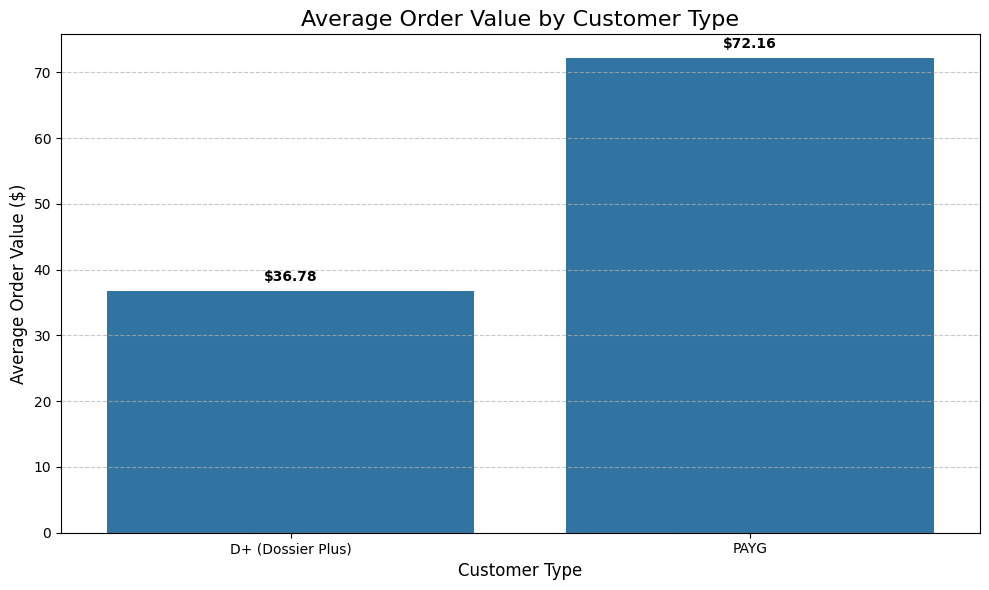

In [26]:
# Calculate AOV by customer type with fixed net_revenue
aov_by_type = order_totals.groupby('customer_type')['net_revenue'].mean().reset_index()
aov_by_type.columns = ['Customer Type', 'Average Order Value']

print("Average Order Value by Customer Type:")
print(aov_by_type)

# Visualize AOV with improved formatting
plt.figure(figsize=(10, 6))
chart = sns.barplot(x='Customer Type', y='Average Order Value', data=aov_by_type)

# Add value labels on top of the bars
for i, value in enumerate(aov_by_type['Average Order Value']):
    chart.text(i, value + 1, f'${value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.title('Average Order Value by Customer Type', fontsize=16)
plt.ylabel('Average Order Value ($)', fontsize=12)
plt.xlabel('Customer Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Task 2: Compare Customer Value - Purchase Frequency

<ipython-input-14-6f0773f9f394>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['order_created_at'].dt.to_period('M')


Purchase Frequency by Customer Type:
       Customer Type  Average Orders per Month
0  D+ (Dossier Plus)                  1.567707
1               PAYG                  1.031289


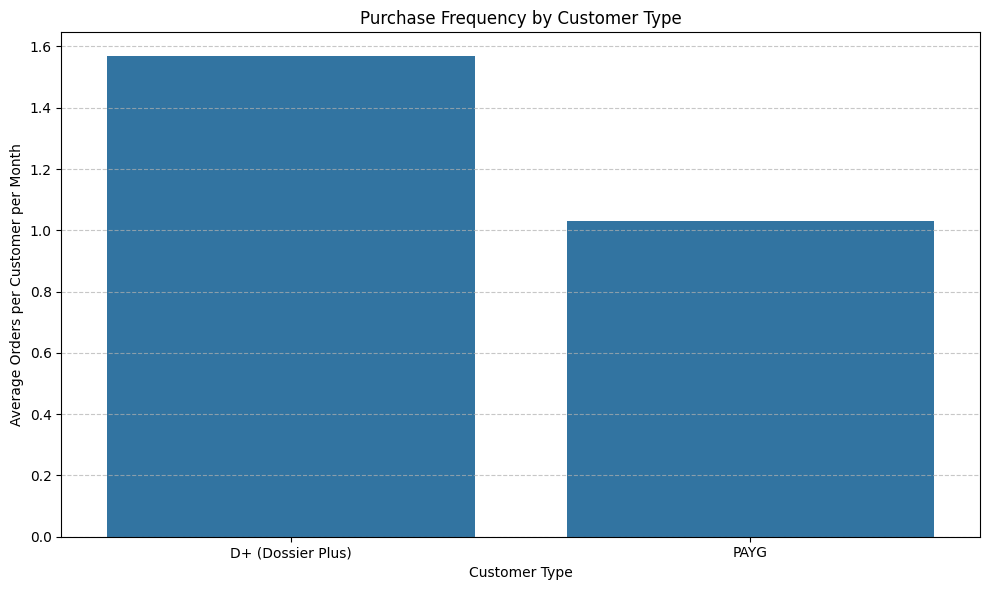

In [14]:
# Add year-month column for time-based analysis
df['year_month'] = df['order_created_at'].dt.to_period('M')

# Count unique orders per customer per month
customer_orders = df.drop_duplicates(['customer_id', 'order_id', 'year_month'])
order_counts = customer_orders.groupby(['customer_id', 'customer_type', 'year_month']).size().reset_index()
order_counts.columns = ['customer_id', 'customer_type', 'year_month', 'order_count']

# Calculate average orders per month for each customer type
purchase_frequency = order_counts.groupby(['customer_type', 'customer_id'])['order_count'].mean().reset_index()
purchase_frequency_by_type = purchase_frequency.groupby('customer_type')['order_count'].mean().reset_index()
purchase_frequency_by_type.columns = ['Customer Type', 'Average Orders per Month']

print("Purchase Frequency by Customer Type:")
print(purchase_frequency_by_type)

# Visualize Purchase Frequency
plt.figure(figsize=(10, 6))
sns.barplot(x='Customer Type', y='Average Orders per Month', data=purchase_frequency_by_type)
plt.title('Purchase Frequency by Customer Type')
plt.ylabel('Average Orders per Customer per Month')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Task 2: Compare Customer Value - Total Revenue Contribution

Number of Dossier Plus subscription entries: 368788

Sample of Dossier Plus product entries:
             order_id  price  quantity  net_revenue
980096  5497291571267   29.0         1         29.0
980097  5497404850243   29.0         1         29.0
980098  5498556448835   29.0         1         29.0
980099  5499379220547    0.0         1          0.0
980100  5499753398339    0.0         1          0.0

Identified 368787 Dossier Plus subscription orders

Distribution of recharge vs non-recharge products:
is_recharge_order
True     732934
False    615950
Name: count, dtype: int64

Total Revenue Contribution by Customer Type:
       Customer Type  Total Revenue (with recharge)  \
0  D+ (Dossier Plus)                   1.572658e+07   
1               PAYG                   1.395637e+07   

   Total Revenue (without recharge)  Recharge Revenue  
0                      2.438601e+06      1.328798e+07  
1                      1.395637e+07      0.000000e+00  

Formatted Revenue Contribution:
  

<Figure size 1200x800 with 0 Axes>

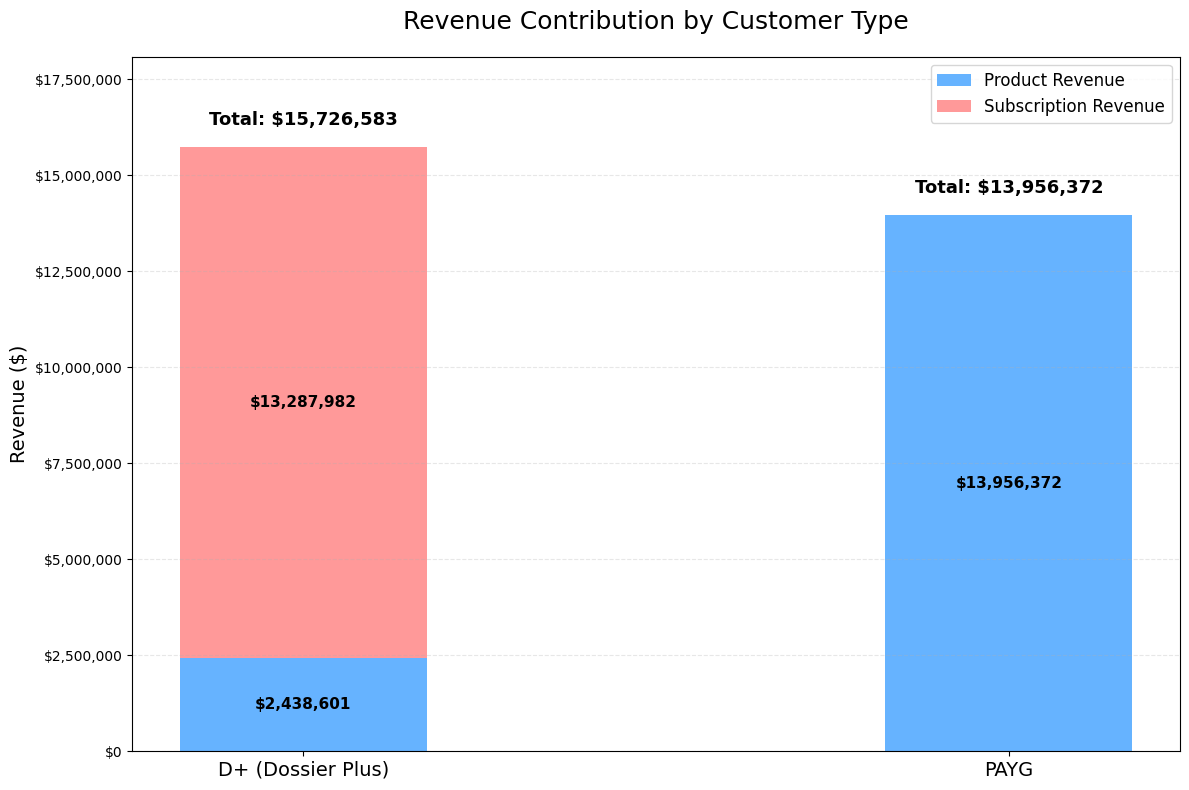


Revenue Breakdown by Customer Type:
D+ (Dossier Plus):
  Product Revenue: $2,438,600.96
  Subscription Revenue: $13,287,982.29
  Total Revenue: $15,726,583.25

PAYG:
  Product Revenue: $13,956,372.08
  Subscription Revenue: $0.00
  Total Revenue: $13,956,372.08



In [30]:
## Task 2: Compare Customer Value - Total Revenue Contribution

# Step 1: Clearly identify Dossier Plus subscription orders (recharge orders)
dossier_plus_orders = df[df['product_name'] == 'Dossier Plus']
print(f"Number of Dossier Plus subscription entries: {len(dossier_plus_orders)}")
print("\nSample of Dossier Plus product entries:")
print(dossier_plus_orders[['order_id', 'price', 'quantity', 'net_revenue']].head(5))

# Step 2: Identify all orders containing Dossier Plus products
recharge_order_ids = df[df['product_name'] == 'Dossier Plus']['order_id'].unique()
print(f"\nIdentified {len(recharge_order_ids)} Dossier Plus subscription orders")

# Step 3: Flag recharge orders in the main dataframe
df['is_recharge_order'] = df['order_id'].isin(recharge_order_ids)

# Step 4: Verify the distribution of recharge vs non-recharge products
print("\nDistribution of recharge vs non-recharge products:")
print(df['is_recharge_order'].value_counts())

# Step 5: Calculate total revenue with and without recharge orders
revenue_with_recharge = df.groupby('customer_type')['net_revenue'].sum().reset_index()
revenue_with_recharge.columns = ['Customer Type', 'Total Revenue (with recharge)']

revenue_without_recharge = df[~df['is_recharge_order']].groupby('customer_type')['net_revenue'].sum().reset_index()
revenue_without_recharge.columns = ['Customer Type', 'Total Revenue (without recharge)']

# Step 6: Merge the results
total_revenue = pd.merge(revenue_with_recharge, revenue_without_recharge, on='Customer Type')

# Explicitly calculate recharge revenue
total_revenue['Recharge Revenue'] = total_revenue['Total Revenue (with recharge)'] - total_revenue['Total Revenue (without recharge)']

print("\nTotal Revenue Contribution by Customer Type:")
print(total_revenue)

# Step 7: Format for presentation
presentation_revenue = total_revenue.copy()
for col in ['Total Revenue (with recharge)', 'Total Revenue (without recharge)', 'Recharge Revenue']:
    presentation_revenue[col] = presentation_revenue[col].apply(lambda x: f"${x:,.2f}")

print("\nFormatted Revenue Contribution:")
print(presentation_revenue)

# Create a cleaner visualization for revenue contribution
plt.figure(figsize=(12, 8))

# Prepare data for plotting
customer_types = total_revenue['Customer Type']
product_revenue = total_revenue['Total Revenue (without recharge)']
recharge_revenue = total_revenue['Recharge Revenue']

# Set up bar positions
x = np.arange(len(customer_types))
width = 0.35

# Create subplots with more room for labels
fig, ax = plt.subplots(figsize=(12, 8))

# Create bars
product_bars = ax.bar(x, product_revenue, width, label='Product Revenue', color='#66b3ff')
recharge_bars = ax.bar(x, recharge_revenue, width, bottom=product_revenue, label='Subscription Revenue', color='#ff9999')

# Customize appearance
ax.set_title('Revenue Contribution by Customer Type', fontsize=18, pad=20)
ax.set_ylabel('Revenue ($)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(customer_types, fontsize=14)
ax.legend(fontsize=12, loc='upper right')

# Add gridlines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)

# Format y-axis with comma separators
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"${x:,.0f}"))

# Add value annotations with better positioning
def add_value_labels(bars, is_bottom=False):
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only add label if there's a value
            y_pos = bar.get_y() + height/2
            if not is_bottom:
                label = f"${height:,.0f}"
            else:
                label = f"${height:,.0f}"

            ax.text(bar.get_x() + bar.get_width()/2, y_pos,
                   label, ha='center', va='center',
                   fontsize=11, fontweight='bold', color='black')

# Add total value labels with better positioning
for i, (prod, rec) in enumerate(zip(product_revenue, recharge_revenue)):
    total = prod + rec
    ax.text(i, total + (max(product_revenue + recharge_revenue) * 0.03),
           f"Total: ${total:,.0f}", ha='center', va='bottom',
           fontsize=13, fontweight='bold')

# Add value labels
add_value_labels(product_bars, is_bottom=True)
add_value_labels(recharge_bars)

# Add more space at the top for labels
plt.ylim(0, max(product_revenue + recharge_revenue) * 1.15)

plt.tight_layout()
plt.show()

# Print formatted values for reference
print("\nRevenue Breakdown by Customer Type:")
for i, ctype in enumerate(customer_types):
    print(f"{ctype}:")
    print(f"  Product Revenue: ${product_revenue.iloc[i]:,.2f}")
    print(f"  Subscription Revenue: ${recharge_revenue.iloc[i]:,.2f}")
    print(f"  Total Revenue: ${(product_revenue.iloc[i] + recharge_revenue.iloc[i]):,.2f}")
    print("")

Task 2: Compare Customer Value - Retention Rate


Overall Retention Rate (customers with more than 1 order):
       customer_type  overall_retention_rate
0  D+ (Dossier Plus)               88.988034
1               PAYG               11.155930

Combined Retention Rates:
       customer_type  overall_retention_rate  product_retention_rate
0  D+ (Dossier Plus)               88.988034               37.206226
1               PAYG               11.155930                     NaN


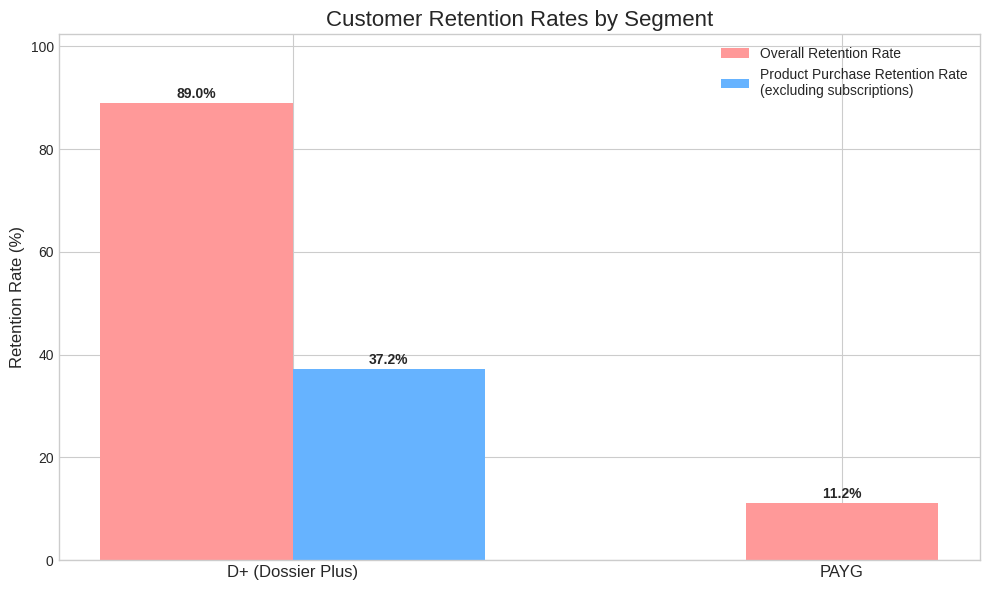

In [48]:
# 1. Calculate Overall Retention Rate (customers who made more than one order)
orders_per_customer = df.drop_duplicates(['customer_id', 'order_id']).groupby(['customer_id', 'customer_type'])['order_id'].count().reset_index()
orders_per_customer.columns = ['customer_id', 'customer_type', 'order_count']

# Calculate retention rate by customer type (% of customers with more than 1 order)
overall_retention = orders_per_customer.groupby('customer_type', as_index=False)['order_count'].apply(
    lambda x: (x > 1).mean() * 100
)
overall_retention.columns = ['customer_type', 'overall_retention_rate']

print("Overall Retention Rate (customers with more than 1 order):")
print(overall_retention)

# 2. Calculate Product-Only Retention Rate for D+ customers
# Get D+ customers
d_plus_customers = df[df['customer_type'] == 'D+ (Dossier Plus)']['customer_id'].unique()

# Identify non-subscription orders for D+ customers
non_sub_orders = df[(df['customer_id'].isin(d_plus_customers)) & (~df['is_recharge_order'])].drop_duplicates(['customer_id', 'order_id'])

# Count non-subscription orders per D+ customer
d_plus_non_sub_count = non_sub_orders.groupby('customer_id')['order_id'].count().reset_index()
d_plus_non_sub_count.columns = ['customer_id', 'non_sub_order_count']

# Calculate product-only retention rate for D+ customers
d_plus_product_retention = (d_plus_non_sub_count['non_sub_order_count'] > 1).mean() * 100

# 3. Create combined retention data - Modified to handle different metrics for different customer types
retention_data = pd.DataFrame({
    'customer_type': ['D+ (Dossier Plus)', 'PAYG'],
    'overall_retention_rate': [
        overall_retention[overall_retention['customer_type'] == 'D+ (Dossier Plus)']['overall_retention_rate'].values[0],
        overall_retention[overall_retention['customer_type'] == 'PAYG']['overall_retention_rate'].values[0]
    ]
})

# Add product retention rate only for D+ customers
retention_data['product_retention_rate'] = [d_plus_product_retention, np.nan]  # Using NaN for PAYG

print("\nCombined Retention Rates:")
print(retention_data)

# 4. Create the visualization - Modified to display different metrics for different segments
fig, ax = plt.subplots(figsize=(10, 6))

# Organize data for plotting
segments = retention_data['customer_type'].tolist()
overall_rates = retention_data['overall_retention_rate'].tolist()

# Create bars - different approach for different segments
# D+ segment with both metrics
ax.bar(0 - 0.175, overall_rates[0], 0.35,
       label='Overall Retention Rate', color=colors[0])
ax.bar(0 + 0.175, retention_data['product_retention_rate'][0], 0.35,
       label='Product Purchase Retention Rate\n(excluding subscriptions)', color=colors[1])

# PAYG segment with only overall metric - centered, no offset
ax.bar(1, overall_rates[1], 0.35, color=colors[0])

# Add value labels
ax.text(0 - 0.175, overall_rates[0] + 1, f'{overall_rates[0]:.1f}%', ha='center', fontweight='bold')
ax.text(0 + 0.175, retention_data['product_retention_rate'][0] + 1, f'{retention_data["product_retention_rate"][0]:.1f}%', ha='center', fontweight='bold')
ax.text(1, overall_rates[1] + 1, f'{overall_rates[1]:.1f}%', ha='center', fontweight='bold')

# Customize appearance
ax.set_ylabel('Retention Rate (%)', fontsize=12)
ax.set_title('Customer Retention Rates by Segment', fontsize=16)
ax.set_xticks([0, 1])
ax.set_xticklabels(segments, fontsize=12)
ax.legend(loc='upper right')
plt.ylim(0, max(overall_rates) * 1.15)

plt.tight_layout()
plt.show()


Task 3: Churn Rate Analysis

Churn Rate by Customer Type:
       Customer Type  Churn Rate (%)
0  D+ (Dossier Plus)       35.555358
1               PAYG       54.061279


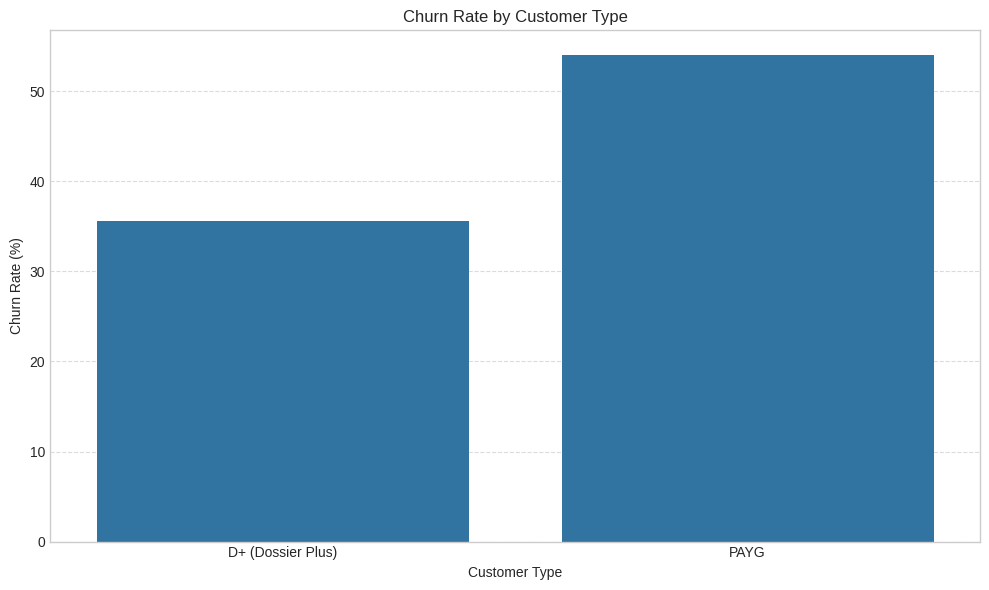

In [50]:
# Get the last date in the dataset
last_date = df['order_created_at'].max()

# Calculate the last purchase date for each customer
last_purchase_date = df.groupby('customer_id')['order_created_at'].max().reset_index()
last_purchase_date.columns = ['customer_id', 'last_purchase_date']

# Calculate days since last purchase
last_purchase_date['days_since_last_purchase'] = (last_date - last_purchase_date['last_purchase_date']).dt.days

# Define churned customers (no purchase in the last 90 days)
last_purchase_date['is_churned'] = last_purchase_date['days_since_last_purchase'] > 90

# Merge with customer type
churn_data = pd.merge(last_purchase_date, df[['customer_id', 'customer_type']].drop_duplicates(), on='customer_id')

# Calculate churn rate by customer type
churn_rate = churn_data.groupby('customer_type')['is_churned'].mean().reset_index()
churn_rate['churn_rate'] = churn_rate['is_churned'] * 100
churn_rate.columns = ['Customer Type', 'is_churned', 'Churn Rate (%)']

print("Churn Rate by Customer Type:")
print(churn_rate[['Customer Type', 'Churn Rate (%)']])

# Visualize Churn Rate
plt.figure(figsize=(10, 6))
sns.barplot(x='Customer Type', y='Churn Rate (%)', data=churn_rate)
plt.title('Churn Rate by Customer Type')
plt.ylabel('Churn Rate (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Task 4: Impact of Store Credit on Retention

Retention Rate for D+ Customers by Store Credit Usage:
   Used Store Credit  Retention Rate (%)
0              False           86.863531
1               True           95.460436


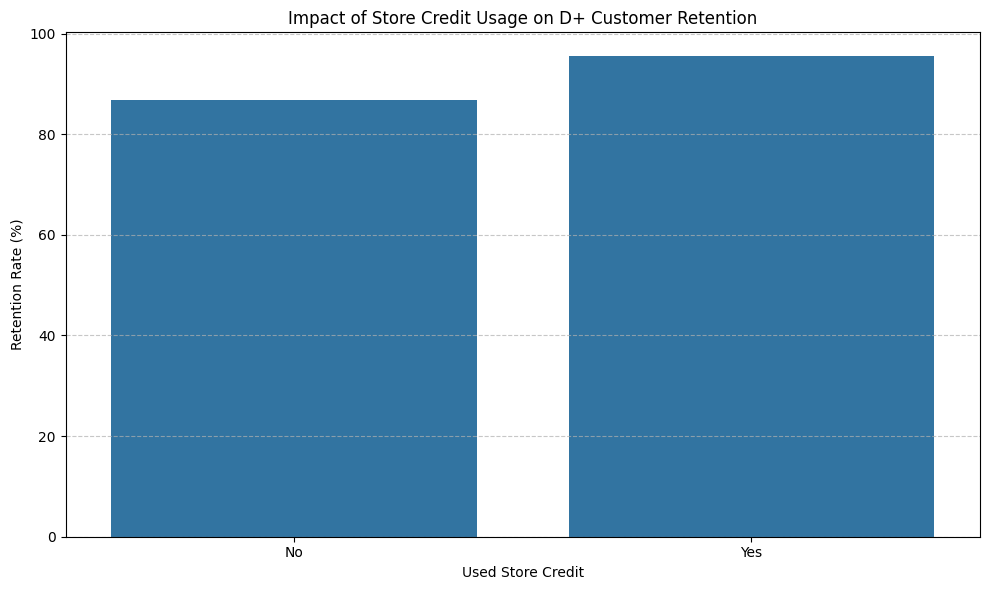

In [19]:
# Focus on D+ customers only
d_plus_customers = df[df['customer_type'] == "D+ (Dossier Plus)"]

# Determine if each customer used store credit
store_credit_usage = d_plus_customers.groupby('customer_id')['store_credit_by_product'].sum().reset_index()
store_credit_usage['used_store_credit'] = store_credit_usage['store_credit_by_product'] != 0

# Get purchase counts for each customer
d_plus_purchase_counts = d_plus_customers.drop_duplicates(['customer_id', 'order_id']).groupby('customer_id')['order_id'].nunique().reset_index()
d_plus_purchase_counts.columns = ['customer_id', 'order_count']

# Merge with store credit usage data
d_plus_retention = pd.merge(d_plus_purchase_counts, store_credit_usage[['customer_id', 'used_store_credit']], on='customer_id')

# Define repeat purchasers
d_plus_retention['has_repeat_purchase'] = d_plus_retention['order_count'] > 1

# Calculate retention rate by store credit usage
retention_by_credit = d_plus_retention.groupby('used_store_credit')['has_repeat_purchase'].mean().reset_index()
retention_by_credit['retention_rate'] = retention_by_credit['has_repeat_purchase'] * 100
retention_by_credit.columns = ['Used Store Credit', 'has_repeat_purchase', 'Retention Rate (%)']

print("Retention Rate for D+ Customers by Store Credit Usage:")
print(retention_by_credit[['Used Store Credit', 'Retention Rate (%)']])

# Visualize the impact of store credit on retention
plt.figure(figsize=(10, 6))
sns.barplot(x='Used Store Credit', y='Retention Rate (%)', data=retention_by_credit)
plt.title('Impact of Store Credit Usage on D+ Customer Retention')
plt.xlabel('Used Store Credit')
plt.ylabel('Retention Rate (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()